In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint

from scipy.optimize import curve_fit

import torchvision.transforms as transforms
from sklearn import preprocessing
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import statsmodels.formula.api as smf
os.chdir("..")
os.getcwd()

'/home/tmuehlenstaedt/ds_experiments/ds_experiments/training_dataset_size_per_class'

### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### logistic regression: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
#results = pd.read_csv("Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_20230628.csv")
results = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
print(results.shape)
results.head(2)

(10800, 13)


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained
0,0.1006,0.868126,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,0
1,0.1314,4.390345,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,5


In [3]:
# Filter data to start with 10 epochs:
# anything below a certain number of epochs seems to be very flaky.
mask = results.epochs_trained >= 10
results = results[mask].reset_index(drop=True)
mask = results_val.epochs_trained >= 10
results_val = results_val[mask].reset_index(drop=True)



In [4]:
classes = results.columns.tolist()[2:12]
print(classes)
results["total_training_size"] = results[classes].sum(axis=1)
results_val["total_training_size"] = results_val[classes].sum(axis=1)
results.head(4)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.1787,4.370253,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,10,4999.0
1,0.2051,4.355270,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,15,4999.0
2,0.2030,4.387133,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,20,4999.0
3,0.2506,4.299767,145.0,31.0,97.0,496.0,1096.0,307.0,2382.0,9.0,373.0,63.0,25,4999.0


In [5]:
### normalize results:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X = results.iloc[:, 1:])
results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
results_scaled.columns = results.iloc[:, 1:].columns
results = pd.concat([results["accs"], results_scaled], axis=1)
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.1787,0.004281,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000,0.000025
1,0.2051,0.003710,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.027027,0.000025


In [6]:
# using the same scaler for train and val:
results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
results_scaled_val.columns = results_val.iloc[:, 1:].columns
results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
results_val.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.2633,0.005252,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.000000,0.0001
1,0.2866,0.009001,0.138187,0.041833,0.040706,0.005404,0.15016,0.019832,0.395143,0.038223,0.151521,0.008002,0.027027,0.0001


In [7]:
# prep data for using class counts:
xdata = np.transpose(results.to_numpy()[:, 2:-1])
y = results.to_numpy()[:, 0]
xdata_val = np.transpose(results_val.to_numpy()[:, 2:-1])
y_val = results_val.to_numpy()[:, 0]
xdata.shape

(11, 10260)

In [8]:
# data for last_epoch_training:
mask = results.epochs_trained == 1
results_last_epoch = results[mask].reset_index(drop=True)
xdata_last_epoch = np.transpose(results_last_epoch.to_numpy()[:, 2:-2])
y_last_epoch = results_last_epoch.to_numpy()[:, 0]

mask = results_val.epochs_trained == 1
results_val_last_epoch = results_val[mask].reset_index(drop=True)
xdata_val_last_epoch = np.transpose(results_val_last_epoch.to_numpy()[:, 2:-2])
y_val_last_epoch = results_val_last_epoch.to_numpy()[:, 0]

In [9]:
# data for total_n and epoch only:
xdata_total_n_epoch = np.transpose(results.to_numpy()[:, -2:])
xdata_val_total_n_epoch = np.transpose(results_val.to_numpy()[:, -2:])
xdata_total_n_epoch.shape

(2, 10260)

In [10]:
# data for last epoch, total_n only:
xdata_last_epoch_total_n = np.transpose(results_last_epoch.to_numpy()[:, -1:])
xdata_val_last_epoch_total_n = np.transpose(results_val_last_epoch.to_numpy()[:, -1:])
xdata_last_epoch_total_n.shape

(1, 270)

In [11]:
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0.1787,0.004281,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000,0.000025
1,0.2051,0.003710,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.027027,0.000025


# logreg - full option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [12]:
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained"
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + np.power(epochs_trained, 2)"
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + np.power(epochs_trained, 2) + I(plane + car + bird + cat + deer + dog + frog + horse + ship + truck) : epochs_trained"
formula = "accs ~ (plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained) ** 2"
formula


'accs ~ (plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained) ** 2'

In [13]:
tmp = smf.glm(formula=formula, data=results, family=sm.families.Binomial()).fit()
print(tmp.summary())
tmp.fittedvalues

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   accs   No. Observations:                10260
Model:                            GLM   Df Residuals:                    10193
Model Family:                Binomial   Df Model:                           66
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4278.0
Date:                Mon, 17 Jul 2023   Deviance:                       100.24
Time:                        23:44:34   Pearson chi2:                     100.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07548
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0062 

0        0.318586
1        0.321730
2        0.324890
3        0.328066
4        0.331257
           ...   
10255    0.813299
10256    0.815045
10257    0.816778
10258    0.818498
10259    0.820206
Length: 10260, dtype: float64

In [14]:
#results = pd.concat([pd.DataFrame({"accs_hat_glm_form": tmp.fittedvalues}), results], axis=1)
results["accs_hat_glm_form"] = tmp.fittedvalues
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,accs_hat_glm_form
0,0.1787,0.004281,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000,0.000025,0.318586
1,0.2051,0.003710,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.027027,0.000025,0.321730


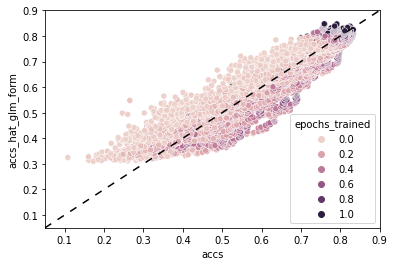

0.8920494585511646

In [15]:
sns.scatterplot(data = results, x="accs", y = "accs_hat_glm_form", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results.accs, results.accs_hat_glm_form)